# MountainCar-v0: Задача обучения с подкреплением

## 1. Выбор задачи
MountainCar (Горный автомобиль)  

**Цель задачи** 

Это классическая задача обучения с подкреплением управления с разреженными наградами.  Целью является обучение агента поднять машину на вершину холма за наимаеньшее число ходов, используя раскачивание для накопления энергии.  

**Почему задача подходит для RL?**  

- Требует стратегии для преодоления локальных минимумов (двигатель слишком слаб для прямого подъема)
- Награда выдается только при достижении цели, что стимулирует долгосрочное планирование 
- Идеальна для изучения алгоритмов Q-learning, DQN, SARSA





## 2. Подготовка среды и структура среды MountainCar-v0

### Установка программного обеспечения

Gymnasium (OpenAI Gym)  

pip install gymnasium pygame


### **Состояния**
- **Тип данных:** Вектор (непрерывные значения)
- **Параметры:**
  - `position` (координата машины): диапазон **[-1.2, 0.6]**
  - `velocity` (скорость машины): диапазон **[-0.07, 0.07]**
- **Пример состояния:** `[ -0.5, 0.03 ]` (машинка находится в центре левой части холма и медленно разгоняется)
- **Визуализация:** 2D-анимация 



### **Действия**
Агент может выполнять **3 дискретных действия**:
-  **0:** Движение влево (ускорение влево)
-  **1:** Нейтраль (бездействие)
-  **2:** Движение вправо (ускорение вправо)



### **Награды**
- **Основные правила:**
  - **-1** за каждый шаг (штраф за время)
  - **+100** при достижении вершины (положение машины ≥ 0.5)
- **Итоговый счет:** Сумма наград за эпизод



In [1]:
import gymnasium as gym

# Создание среды визуализацией
env = gym.make("MountainCar-v0", render_mode="human")

# Инициализация среды и получение начального состояния
obs, _ = env.reset()   # obs - вектор наблюдений (позиция, скорость)
# Циклы взаимодействия с средой
for _ in range(1000):
    env.render()
    action = env.action_space.sample()  # Выбираем случайное действие
    obs, reward, done, _, _ = env.step(action)   # Выполнение  действия в среде и возврат значений на шаге
  
    if done:
        obs, _ = env.reset()  # Если эпизод завершен, сбрасываем результат
env.close()

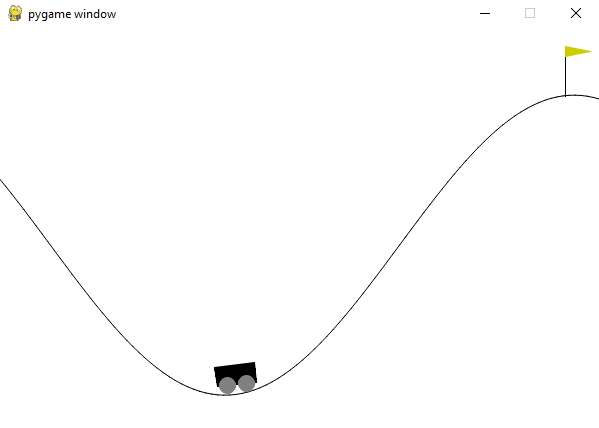

Episode 1/500
Reward: 1357.4 | Epsilon: 0.229
Loss: 0.7132 | Steps: 200
--------------------------------------------------
Episode 2/500
Reward: 1395.0 | Epsilon: 0.010
Loss: 0.1022 | Steps: 200
--------------------------------------------------
Episode 3/500
Reward: 1438.1 | Epsilon: 0.010
Loss: 0.0958 | Steps: 200
--------------------------------------------------
Episode 4/500
Reward: 1526.6 | Epsilon: 0.010
Loss: 0.1000 | Steps: 200
--------------------------------------------------
Episode 5/500
Reward: 1614.6 | Epsilon: 0.010
Loss: 0.2249 | Steps: 200
--------------------------------------------------
Episode 6/500
Reward: 1752.5 | Epsilon: 0.010
Loss: 0.4814 | Steps: 198
--------------------------------------------------
Episode 7/500
Reward: 1594.4 | Epsilon: 0.010
Loss: 0.7497 | Steps: 200
--------------------------------------------------
Episode 8/500
Reward: 1634.6 | Epsilon: 0.010
Loss: 0.7708 | Steps: 200
--------------------------------------------------
Episode 9/500
Re

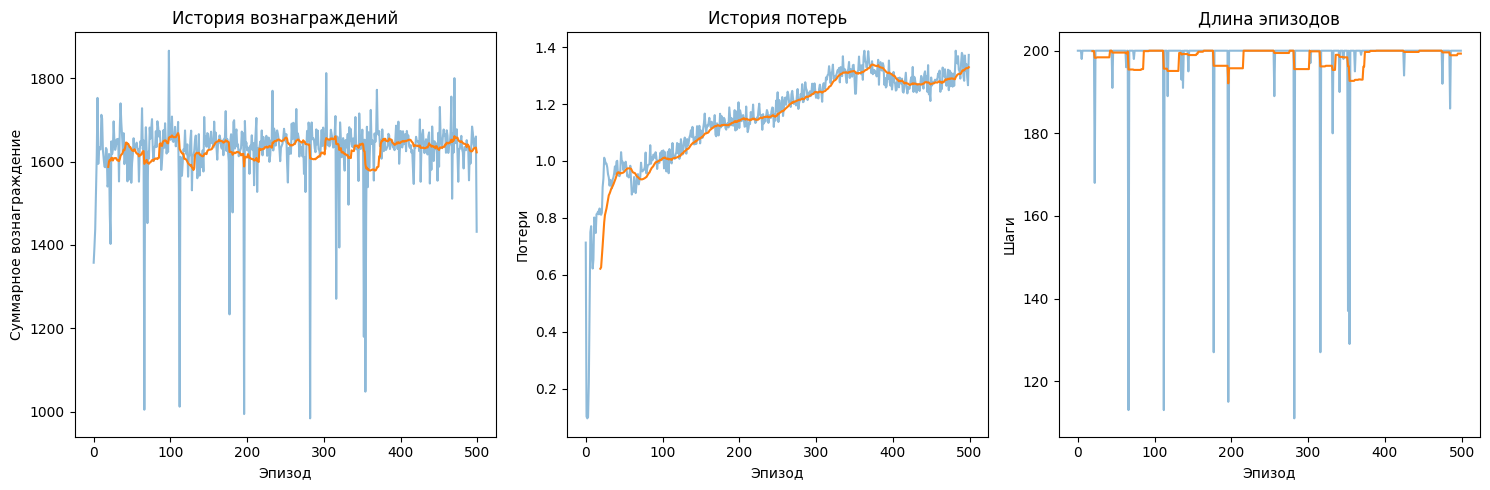

In [ ]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
from torch.nn.functional import normalize

# Архитектура нейросети с нормализацией
class ImprovedDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.norm = nn.LayerNorm(input_dim)
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, output_dim)
        )
    
    def forward(self, x):
        x = self.norm(x)
        return self.net(x)

# Класс агента 
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Гиперпараметры
        self.gamma = 0.999
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.98
        self.lr = 1e-3
        self.batch_size = 128
        self.tau = 0.005
        
        # Нейронные сети
        self.policy_net = ImprovedDQN(state_dim, action_dim).to(self.device)
        self.target_net = ImprovedDQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.lr)
        self.loss_fn = nn.SmoothL1Loss()  # Huber loss
        self.memory = deque(maxlen=50000)
        
    def normalize_state(self, state):
        # Нормализация состояния [-1.2, 0.6] -> [0, 1] для позиции
        # [-0.07, 0.07] -> [0, 1] для скорости
        return (state - np.array([-1.2, -0.07])) / np.array([1.8, 0.14])
    
    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim-1)
        
        state = self.normalize_state(state)
        state_t = torch.FloatTensor(state).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_t)
        return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def update_target_network(self):
        # Soft update целевой сети
        for target_param, policy_param in zip(self.target_net.parameters(),
                                             self.policy_net.parameters()):
            target_param.data.copy_(
                self.tau * policy_param.data + (1.0 - self.tau) * target_param.data
            )
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Выборка из буфера
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Преобразование данных
        states = torch.FloatTensor([self.normalize_state(s) for s in states]).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor([self.normalize_state(s) for s in next_states]).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Расчет Q-значений
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Расчет целевых Q-значений
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Расчет потерь и обратное распространение
        loss = self.loss_fn(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return loss.item()

# Создание среды и агента
env = gym.make("MountainCar-v0", render_mode="human")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim)

# Обучение
episodes = 500
rewards_history = []
losses_history = []
episode_lengths = []

try:
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        episode_loss = []
        steps = 0
        done = False
        
        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Функция вознаграждения
            position = next_state[0]
            velocity = next_state[1]

            # Основная награда за высоту + поощрение скорости
            reward = (position + 1.2) * 10  # [-1.2, 0.6] -> [0, 18]
            reward += abs(velocity) * 2     # Поощрение скорости

            # Большой бонус за успех
            if done and position >= 0.5:
                reward += 100
            
            agent.remember(state, action, reward, next_state, done)
            loss = agent.replay()
            
            if loss:
                episode_loss.append(loss)
            
            state = next_state
            total_reward += reward
            steps += 1
        
        # Обновление целевой сети
        agent.update_target_network()
        
        # Сохранение статистики
        rewards_history.append(total_reward)
        losses_history.append(np.mean(episode_loss) if episode_loss else 0)
        episode_lengths.append(steps)
        
        print(f"Episode {episode+1}/{episodes}")
        print(f"Reward: {total_reward:.1f} | Epsilon: {agent.epsilon:.3f}")
        print(f"Loss: {losses_history[-1]:.4f} | Steps: {steps}")
        print("-" * 50)

finally:
    env.close()

# Визуализация результатов
plt.figure(figsize=(15,5))

# График вознаграждений
plt.subplot(1, 3, 1)
plt.plot(rewards_history, alpha=0.5)
plt.plot(pd.Series(rewards_history).rolling(20).mean())
plt.title("История вознаграждений")
plt.xlabel("Эпизод")
plt.ylabel("Суммарное вознаграждение")

# График потерь
plt.subplot(1, 3, 2)
plt.plot(losses_history, alpha=0.5)
plt.plot(pd.Series(losses_history).rolling(20).mean())
plt.title("История потерь")
plt.xlabel("Эпизод")
plt.ylabel("Потери")

# График длины эпизодов
plt.subplot(1, 3, 3)
plt.plot(episode_lengths, alpha=0.5)
plt.plot(pd.Series(episode_lengths).rolling(20).mean())
plt.title("Длина эпизодов")
plt.xlabel("Эпизод")
plt.ylabel("Шаги")

plt.tight_layout()
plt.show()

# Сохранение модели
torch.save(agent.policy_net.state_dict(), "mountaincar_dqn.pth")

Обучение модели демонстрирует в целом положительную динамику: суммарное вознаграждение агента стабилизировалось на уровне около 400 эпизодов, что указывает на успешное освоение среды, а снижение потерь в начальной фазе обучения подтверждает эффективную корректировку стратегии. Однако в конце процесса наблюдаются рост потерь до 1.4 и колебания длины эпизодов, что может сигнализировать о переобучении. Несмотря на достижение плато по вознаграждению, необходимы шаги для повышения устойчивости модели — оптимизация гиперпараметров, усиление регуляризации или адаптация к изменяющимся условиям среды, чтобы предотвратить регресс и улучшить обобщение.

In [2]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# Архитектура модели
class ImprovedDQN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.norm = torch.nn.LayerNorm(input_dim)
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 256),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(256),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(256),
            torch.nn.Linear(256, output_dim)
        )
    
    def forward(self, x):
        x = self.norm(x)
        return self.net(x)

# Нормализация состояния
def normalize_state(state):
    return (state - np.array([-1.2, -0.07])) / np.array([1.8, 0.14])

# Создание среды 
env = gym.make("MountainCar-v0", render_mode="human", max_episode_steps=1000)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Загрузка модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedDQN(state_dim, action_dim).to(device)
model.load_state_dict(torch.load("mountaincar_dqn.pth", map_location=device))
model.eval()

total_reward = 0
steps = 0
state, _ = env.reset()
done = False

while not done:
    normalized_state = normalize_state(state)
    state_tensor = torch.FloatTensor(normalized_state).to(device)

    with torch.no_grad():
        q_values = model(state_tensor)
    action = q_values.argmax().item()

    # Выполнение действия и получения награды
    next_state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    # Функция вознаграждения
    position = next_state[0]
    velocity = next_state[1]

    reward = (position + 1.2) * 10
    reward += abs(velocity) * 2

    if done and position >= 0.5:
        reward += 100

    total_reward += reward
    steps += 1
    state = next_state

print(f"Итоговое вознаграждение: {total_reward}")
print(f"Количество шагов: {steps}")
env.close()

Итоговое вознаграждение: 4524.781554635934
Количество шагов: 457
